# Time stability

In [1]:
include("smij-functions.jl");

## Stability regions

A multistep formula can be written in the form

$$
\rho(\mathcal(Z)) u_n = \tau \sigma(\mathcal{Z}) f(t_n,u_n), 
$$

where $\mathcal{Z}$ is the forward shift operator, $\rho$ is a polynomial of degree $m$, which is the number of steps, and $\sigma$ is a polynomial of degree $m$ (implicit formula) or less (explicit formula). If we look for exponential solutions of the form $u_n=z^n$ for all $n$, then we can replace $\mathcal{Z}$ by $z$. For the linear problem $u'=\lambda u$ of absolute stability, this becomes

$$
\frac{\rho(z)}{\sigma(z)} = \tau \lambda = \zeta. 
$$

The boundary of the stability region is when $|z|=1$, since that represents solutions that neither grow nor decay in time. All points on this boundary, then, are of the form $\frac{\rho(z)}{\sigma(z)}$ for some $z=e^{i\theta}$. 

(The boundary of the stability region for an RK formula is a little trickier to work out.)

### p25: stability regions for ODE formulas

In [2]:
using Polynomials
function ABregion(order)
    ρ = Polynomial([zeros(order-1);-1;1])
    σ = Polynomial( ([1], [-1,3]/2, [5,-16,23]/12)[order] )
    z = cis.(2π*(0:360)/360)
    return @. ρ(z) / σ(z)
end

function AMregion(order)
    ρ = Polynomial([zeros(order-2);-1;1])
    s = ([], [], [-1,8,5]/12, [1,-5,19,9]/24, 
            [-19,106,-264,646,251]/720, [3/160,-173/1440,241/720,-133/240,1427/1440,95/288])
    σ = Polynomial( s[order] )
    z = cis.(2π*(0:360)/360)
    return @. ρ(z) / σ(z)
end

function BDregion(order)
    z = cis.(2π*(0:360)/360)
    d = @. 1 - 1/z
    p = Polynomial([0; 1 ./ (1:order)])
    return p.(d)
end

function RKregion(order)
    T0 = Polynomial([1/factorial(k) for k in 0:order])
    T1 = Polynomial([1/factorial(k) for k in 0:order-1])
    z = cis.(2π*(0:360)/360)
    W = fill(complex(0.0),360)
    w = 0;
    for (k,z) in enumerate(z[2:end])
        w -= (T0(w) - z^order) / T1(w)
        W[k] = w
    end
    return W
end;

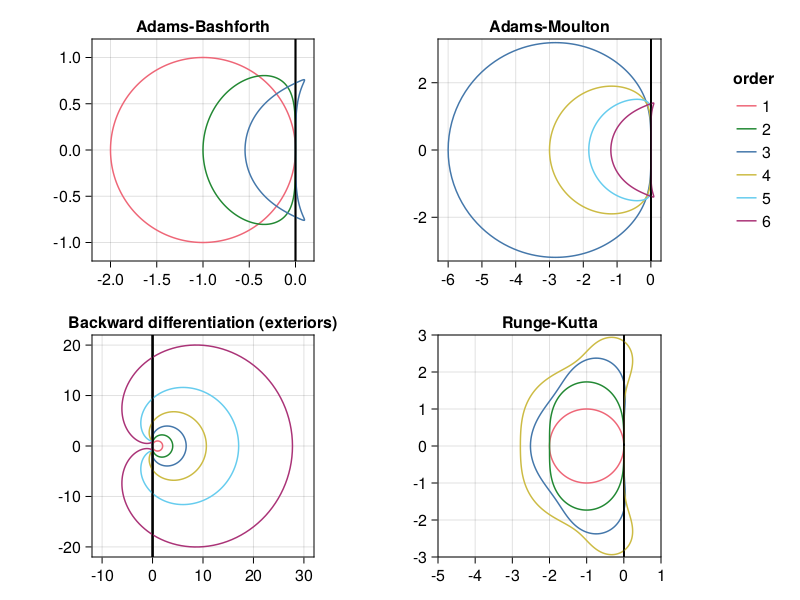

In [3]:
using CairoMakie
using Makie.ColorSchemes

colors = ColorSchemes.tol_bright[1:6]

data = [
    (ABregion, 1:3, [-2.2,0.2,-1.2,1.2], "Adams-Bashforth"),
    (AMregion, 3:6, [-6.3,0.3,-3.3,3.3], "Adams-Moulton"),
    (BDregion, 1:6, [-12,32,-22,22], "Backward differentiation (exteriors)"),
    (RKregion, 1:4, [-5,1,-3,3], "Runge-Kutta")
]

fig = Figure()
ax = vec([Axis(fig[j,i], aspect=DataAspect()) for i in 1:2, j in 1:2])
for (ax,(kind,orders,limits,title)) in zip(ax,data)
    for order in orders
        w = kind(order)
        lines!(ax,real(w),imag(w), label="$order", color=colors[order])
        limits!(ax,limits...)
        ax.title = title
        vlines!(ax,0, color=:black)
    end
end

Legend(fig[1,3], ax[3], "order", framevisible=false)
fig

## Eigenvalues of spectral differentiation


### First derivative

Consider again the linear advection equation, $\partial_t u + c\partial_x u = 0$, with periodic boundary conditions. Recall that when the space derivative is discretized by a second-order central difference with grid spacing $h$, the eigenvalues of the semidiscrete problem are in the imaginary interval bounded by $\pm c i/h$. If we use the leapfrog method for time stepping (also a centered difference, but in time), this gives the time step restriction 

$$
\tau \le \frac{h}{|c|}. 
$$

If we instead use Fourier spectral differentiation in space, the spectrum (via diagonalization in Fourier space) is $\{0,\pm i,\dots,\pm i(\tfrac{N}{2}-1)\}$. Thus the restriction is

$$
\tau \le \frac{1}{|c| (\tfrac{N}{2}-1)  } \approx  \frac{2}{|c| N} =  \frac{h}{|c| \pi}.
$$

This is more restrictive than the FD case by a factor of $\pi$, but the restriction is due entirely to a more accurate representation of the derivative operator on the grid. 

Revisiting the [variable-speed equation](dft) with $c(x) = 0.2 + \sin^2(x-1)$, the eigenvalues of $\operatorname{diagm}(c(\bfx)) \bfD$ are not exactly values of $c$ times the eigenvalues of $\bfD$, but we can estimate that they will be bounded by a scaling of $\max |c(x)| = 6/5$. This suggests a restriction

$$
\tau \le \frac{5}{3N} = 1.67 N^{-1}. 
$$

This proves to be a bit pessimistic; in the following simulation, the instability becomes evident when $\tau N \approx 1.9$.

In [4]:
using FFTW

function p6(⍺ = 1.57)
    # Grid, variable coefficient, and initial data:
    N = 128;  h = 2π / N
    x = h * (1:N)
    t = 0;  Δt = ⍺ / N
    c = @. 0.2 + sin(x - 1)^2
    v = @. exp(-100 * (x - 1) .^ 2)
    vold = @. exp(-100 * (x - 0.2Δt - 1) .^ 2)

    # Time-stepping by leap frog formula:
    tmax = 8
    nsteps = ceil(Int, tmax / Δt)
    Δt = tmax / nsteps
    V = [v fill(NaN, N, nsteps)]
    t = Δt*(0:nsteps)
    for i in 1:nsteps
        w = fderiv(V[:,i])
        V[:,i+1] = vold - 2Δt * c .* w
        vold = V[:,i]
        if norm(V[:,i+1], Inf) > 2.5
            nsteps = i
            break 
        end
    end
    return x,t[1:nsteps+1],V[:,1:nsteps+1]
end

x,t,V = p6(1.9);

using CairoMakie, PyFormattedStrings

fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="u"
)
lines!(x, @lift(V[:,$index]))
record(fig, "p6unstable.mp4", 1:4:size(V,2)+1) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
end;

<video autoplay width=480 controls><source src="p6unstable.mp4" type="video/mp4"></video>

Observe above that the failure becomes visible first in the sawtooth mode, which lies at the edges of the spectrum.

### Second derivative

Now consider the wave equation, $\partial_{tt} u = \partial_{xx} u$ on a bounded domain with homogeneous Dirichlet conditions. If $\bfD_{xx}$ is the second-derivative matrix on a Chebyshev grid, then we can impose the boundary conditions by deleting the endpoint values, resulting in

$$
\partial_{tt} \bfC^T \bfu = \bfC^T \bfD_{xx} \bfC (\bfC^T \bfu),
$$

where $\bfC$ is the $(N+1)\times (N-1)$ matrix that chops off the first and last columns. Hence the eigenvalues of $\bfC^T \bfD_{xx} \bfC$ determine the stability restriction. They turn out to be negative and real.

### p26: eigenvalues of 2nd-order Chebyshev diff. matrix

In [5]:
N = 60
D, x = cheb(N)
D² = (D^2)[2:N, 2:N]   # chop
λ, V = eigen(D², sortby=(-)∘real)

xx = -1:0.01:1
vN4 = [0; V[:,N ÷ 4 - 1]; 0]
vvN4 = polyinterp(x, vN4).(xx)
vN = [0; V[:, N-1]; 0];

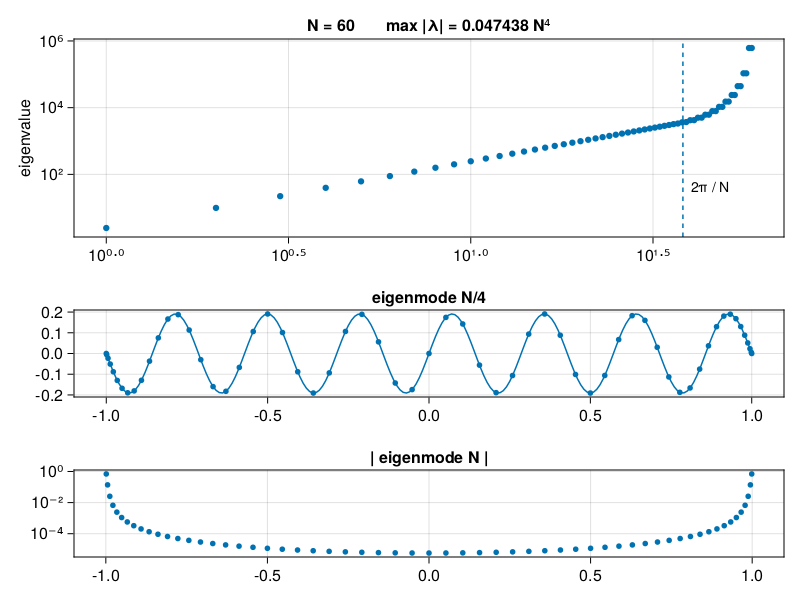

In [6]:
using PyFormattedStrings
# Plot eigenvalues:
fig = Figure()
M = maximum(-λ)/N^4
ax = Axis(fig[1:2,1], 
    xscale=log10, yscale=log10, ylabel="eigenvalue",
    title=f"N = {N}       max |λ| = {M:.6f} N⁴" )
    
scatter!(-λ, markersize=9)
vlines!(ax, 2N / π, linestyle=:dash)
text!(2.1N / π, 24, text="2π / N", textsize=14)

# Plot eigenmodes N/4 (physical) and N (nonphysical):
ax = Axis(fig[3,1], title="eigenmode N/4")
lines!(xx, vvN4)
scatter!(x, vN4, markersize=8)

ax = Axis(fig[4,1], title="| eigenmode N |", yscale=log10)
scatter!(x[2:N], abs.(vN[2:N]), markersize=8)
fig

As we argued earlier about PPW, the best a Chebyshev method can do is resolve modes up to wavenumber $N/\pi$, compared to $N/2$ in the Fourier case, due to the coarse spacing in the middle of the grid. The output above shows that mode $N/4$ is indeed well represented. However, one can prove that there are additional outlying eigenvalues of size $\sim 0.048N^4$. These affect the stability criterion despite the fact that they represent nothing meaningful about the PDE. 

For our earlier wave equation demonstrations, we use leapfrog on the $\partial_{tt}u$ term:

$$
\frac{u_{n-1}-2u_n+u_{n+1}}{\tau^2} = f(t_n,u_n). 
$$

Assuming $f(t,u)=\lambda u$, an exponential solution of the form $u_n=z^n$ leads to

$$
z^{-1} - 2 + z = \tau^2 \lambda. 
$$

If $z$ is a root of this equation, then so is $z^{-1}$, so $|z|=1$ is required for stability. With $z=e^{i\theta}$, 

$$
2[\cos(\theta)-1] = \tau^2 \lambda. 
$$

We therefore conclude that $\tau^2 \lambda \in [-4,0]$ for stability. In the context of the wave equation, this means $-0.048 N^2 \tau^2 \ge -4$, or 

$$
\tau \le \sqrt{ 4/0.048}\, N^{-2} = 9.13 N^{-2}. 
$$

If this criterion is not met, the most affected modes are the outliers which, according to the output above, are small away from the boundaries.

Here is a reprise of [p19](chebfft) using $\tau = 9.2/N^2$.


### p19u: UNSTABLE wave eq.

In [7]:
# Time-stepping by leap frog formula:
N = 80
_, x = cheb(N)
Δt = 9.2 / N^2
v = @. exp(-200 * x^2)
vold = @. exp(-200 * (x - Δt)^2)

tmax = 4
nsteps = ceil(Int, tmax / Δt)
Δt = tmax / nsteps
V = [v fill(NaN, N+1, nsteps)]
t = Δt*(0:nsteps)
for i in 1:nsteps
    w = chebfft(chebfft(V[:,i]))
    w[1] = w[N+1] = 0
    V[:,i+1] = 2V[:,i] - vold + Δt^2 * w
    vold = V[:,i]
    if norm(V[:,i+1], Inf) > 12
        nsteps = i
        break 
    end
end

t = t[1:nsteps]
V = V[:,1:nsteps];

fig = Figure(size=(480,360))
index = Observable(1)
ax = Axis(fig[1, 1],xlabel="x", ylabel="u" )
lines!(x, @lift(V[:,$index]))
record(fig, "p19u.mp4", 1:6:size(V,2)) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
    limits!(-1.06,1.06,-1.5,1.5)
end;

<video autoplay width=480 controls><source src="p19u.mp4" type="video/mp4"></video>

In two dimensions, one can show that $\lambda$ is twice as large, which means that $\tau$ must be $\sqrt{2}$ times smaller, or $\tau \le 6.5/N^2$. Here is a repeat of p20 using $\tau = 6.6/N^2$.

### p20u: UNSTABLE wave eq. in 2D

In [8]:
# Grid and initial data:
N = 32
x = y = cheb(N)[2]
Δt = 6.6 / N^2
xx = yy = range(-1,1,81)
nsteps = ceil(Int, 1 / Δt)
Δt = 1 / nsteps

vv = [exp(-40 * ((x - 0.4)^2 + y^2)) for x in x, y in y]
vvold = vv

t = Δt*(0:nsteps)
V = zeros(length(xx),length(yy),nsteps+1)
V[:,:,1] = gridinterp(vv,xx,yy)

# Time-stepping by leap frog formula:
uxx = zeros(N+1, N+1)
uyy = zeros(N+1, N+1)
for n in 1:nsteps
    ii = 2:N
    for i in 2:N
        uxx[i,:] .= chebfft(chebfft(vv[i,:]))
        uyy[:,i] .= chebfft(chebfft(vv[:,i]))
    end
    uxx[[1,N+1],:] .= uyy[[1,N+1],:] .= 0
    uxx[:,[1,N+1]] .= uyy[:,[1,N+1]] .= 0
    vvnew = 2vv - vvold + Δt^2 * (uxx + uyy)
    vvold,vv = vv,vvnew
    V[:,:,n+1] = gridinterp(vv,xx,yy)
    if norm(V[:,:,n+1]) > 8
        nsteps = n+1
        break
    end
end

V = V[:,:,1:nsteps];

fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis3(fig[1, 1], xlabel="x", ylabel="y")
co = surface!(xx, yy, @lift(V[:,:,$index]), 
        colormap=:bluesreds, colorrange=[-1,1] )
record(fig, "p20u.mp4", 1:nsteps) do i
    index[] = i
    ax.title = f"t = {t[i]:.2f}"
    limits!(ax,-1,1,-1,1,-1,1)
end;

<video autoplay width=480 controls><source src="p20u.mp4" type="video/mp4"></video>

## Integrating factor

The **KdV equation** is

$$
\partial_t u + u \partial_x u + \partial_{xxx} u = 0. 
$$

Unusually for a nonlinear equation, it admits solutions called *solitons* that maintain their shape:

$$
u(x,t) = 3a^2 \operatorname{sech}^2\bigl[ a(x-x_0)/2 - a^3t\bigr], 
$$

The amplitude and velocity of this soliton are $3a^2$ and $2a^2$, so taller solitons travel faster than shorter ones. 

Let's assume periodic conditions, since the soliton solutions decay rapidly. If we straightforwardly apply the method of lines in a Fourier discretization, then we have to deal with the eigenvalues of the third derivative operator, which are $\sim \pm i N^3/8$. Any regular explicit time stepping method will end up with a restriction $\tau = O(N^{-3})$. We could use trapezoid, which has no restriction but is limited to 2nd order. However, there is an alternative (actually, several) worth considering.

The term causing stiffness in KdV is linear, which creates an opportunity to use a hybrid approach. Consider the PDE transformed into Fourier space,

$$
\partial_t \hat{u} + \tfrac{1}{2} ik \widehat{u^2} - ik^3 \hat{u} = 0, 
$$

where we used $\partial_x (u^2)=uu_x$, although this is not important here. Borrowing from linear ODE tricks, we multiply the ODE through by the **integrating factor** $\exp(-ik^3t)$ and rewrite as

$$
\partial_t \left[ e^{-ik^3t} \hat{u} \right] + \tfrac{1}{2} ik e^{-ik^3t} \widehat{u^2}  = 0. 
$$

This suggests actually solving for $z = e^{-ik^3t} \hat{u}$ as the ODE unknown, because the stiff term has been absorbed. In order to calculate $\partial_t z$ for the IVP solver, we go through a few steps:

$$
\hat{u} &= e^{ik^3t} z \\ 
u &= \mathcal{F}_N^{-1}[\hat{u}] \\ 
\partial_t z &= -\tfrac{1}{2} ik e^{-ik^3t} \mathcal{F}_N[u^2]. 
$$

Within the context of a Runge--Kutta method, we can restart the integrating factor at time zero at each step, which is more robust than using $t^3$ as $t\to\infty$.  

### p27: Solve KdV eq.

In [9]:
using FFTW

# Set up grid and two-soliton initial data:
N = 256
τ = 0.4 / N^2
x = (2π / N) * (-N/2 : N/2-1)
soliton(a,x) = 3a^2 * sech(0.5 * (a * x))^2
A, B = 25, 16
u = @. soliton(25, x+2) + soliton(16, x+1) 
û = fft(u)
k = [0:N/2-1; 0; -N/2+1:-1]
ik3 = 1im * k .^ 3

# Solve PDE and plot results:
tmax = 0.006
nsteps = ceil(Int, tmax / τ)
τ = tmax / nsteps
t = τ * (0:nsteps)
U = zeros(N,nsteps+1)
U[:,1] .= u

g = -0.5im * τ * k          # for the nonlinear term
E = exp.(τ * ik3 / 2)       # for the integrating factor   
E² = E .^ 2
nonlin(û) = fft( real(ifft(û)) .^ 2 )
for n = 1:nsteps
    a = g .* nonlin(û)
    b = g .* nonlin(E .* (û+a/2))        # 4th-order
    c = g .* nonlin(E.*û + b/2)          # Runge-Kutta
    d = g .* nonlin(E².*û + E.*c)
    û = @. E² * û + (E² * a + 2 * E * (b + c) + d) / 6
    
    U[:,n+1] = real( ifft(û) )      # only needed for plotting
end

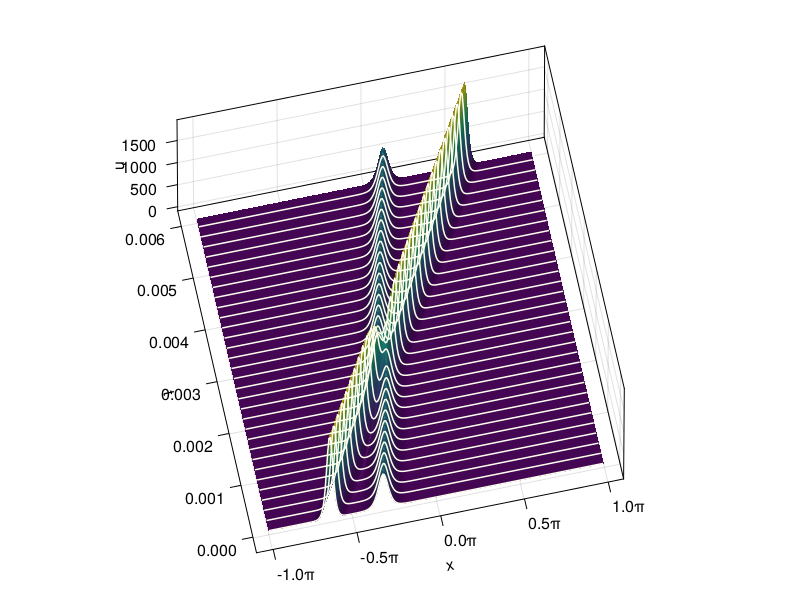

In [10]:
fig = Figure()
Axis3(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="t", zlabel="u", 
    azimuth=4.5, elevation=1.2,
)
gap = max(1,round(Int, 2e-4/(t[2]-t[1])) - 1)
surface!(x, t, U)
[ lines!(x, fill(t[j], length(x)), U[:, j].+.01, color=:ivory) for j in 1:gap:size(U,2) ]
fig

In [11]:
fig = Figure(size=(480,320))
index = Observable(1)
ax = Axis(fig[1, 1],
    xticks = MultiplesTicks(5, π, "π"),
    xlabel="x", ylabel="u"
)
lines!(x, @lift(U[:,$index]))
record(fig, "p27.mp4", 1:6:size(U,2)) do i
    index[] = i
    ax.title = f"t = {t[i]:.5f}"
end;

<video autoplay width=480 controls><source src="p27.mp4" type="video/mp4"></video>


Note from the results above that the solitons pass through each other unchanged in shape, but phase-shifted in spacetime.

The integrating factor trick is easy but not always the best choice among hybrid *implicit--explicit* solvers.